In [1]:
import numpy as np
import logging
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

try:
  import user_project_config as conf
except:
  import project_config as conf

from IO import data_loading as dl
from utils import logg 
from utils import data_processing as dp
from models_utils import models_utils as mu


from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

import xgboost as xgb #!!!

%matplotlib inline

In [2]:
import sklearn
sklearn.__version__

'0.17'

In [7]:
#!!!
USED_EXAMPLES_NUMBER = None # 'None' means that all examples are used; otherwise randomly selected

#!!!
OBJECTIVE_NAME = 'cl_sleep_interval' # e.g. 'BMIgr', 'Sex', 'cl_sleep_interval' #!!!!
sample_name = OBJECTIVE_NAME + '_3' # train-test filename
SEED = 0


classifiers = [
  ("XGBoost", xgb.XGBClassifier()),
  ("Dummy", DummyClassifier(strategy='stratified')), # see http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
  # ("Linear SVM", SVC(kernel="linear", C=0.025)),
  # ("RBF SVM", SVC(gamma=2, C=1)),
  # ("Decision Tree", DecisionTreeClassifier(max_depth=5)),
  ("Random Forest", RandomForestClassifier(n_estimators=100)),
  ("Nearest Neighbors", KNeighborsClassifier(3)),
  # ("AdaBoost", AdaBoostClassifier()),
  ("Naive Bayes", GaussianNB())
  ] # TODO: xgboost

###############################################################
# Initial configuration
np.random.seed(SEED)

In [10]:
trainX, trainY, testX, testY, sample_info = dl.load_hdf5_sample(sample_name)

trainX2, trainY2, testX2, testY2, sample_info2 = dl.load_hdf5_sample(sample_name+'b')

print trainX.shape, trainX2.shape
trainX = np.hstack((trainX, trainX2))
testX = np.hstack((testX, testX2))

print trainX.shape
print len(sample_info['Features names'])
trainX[0]
print sample_info['Features names']

(327834, 38) (327700, 1)


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [5]:
trainX.shape[0] + testX.shape[0]


#print np.any(np.isnan(trainX[:, 13])==False)
sample_info['Features names'][13]

nans_counter = np.sum(np.isnan(trainX[:, :]), axis=0) + np.sum(np.isnan(testX[:, :]), axis=0)
#np.array(sample_info['Features names'])[ind]
ind = nans_counter == 0

#print np.sum(np.isnan(testX[:, :]), axis=0)
nans_counter

np.array(sample_info['Features names'])[~ind]
nans_counter

IndexError: list index out of range

In [6]:
clf = xgb.XGBClassifier()
clf.fit(trainX, trainY)

from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score

def show_results(clf, testX, testY):
    predictions = clf.predict(testX)
    actuals = testY
    cm = confusion_matrix(actuals, predictions)
    print(cm)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm_normalized)
    print 'accuracy', accuracy_score(actuals, predictions)
    
    
show_results(clf, testX, testY)

[[86712  6208]
 [ 5134 41927]]
[[ 0.93318984  0.06681016]
 [ 0.10909245  0.89090755]]
accuracy 0.918974717997


/home/iv/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
clf = RandomForestClassifier(n_estimators=100)#xgb.XGBClassifier()
clf.fit(trainX[:, ind], trainY)
show_results(clf, testX[:, ind], testY)

[[79372 13096]
 [14712 32381]]
[[ 0.85837263  0.14162737]
 [ 0.31240312  0.68759688]]
accuracy 0.800746626923


/home/iv/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [ ]:
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE


clf = RandomForestClassifier(n_estimators=100) #xgb.XGBClassifier()

rfe = RFE(clf, 5)
rfe = rfe.fit(trainX[:, ind], trainY)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

/home/iv/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 327834 but corresponding boolean dimension is 38
  from ipykernel import kernelapp as app


((327834, 34), (34, 1))

In [9]:
np.any(np.isnan(trainX[:, ~ind]))
ind
trainX[:, ind].shape, trainY[ind].shape

/home/iv/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 327834 but corresponding boolean dimension is 38
  app.launch_new_instance()


((327834, 34), (34, 1))

Automatically created module for IPython interactive environment


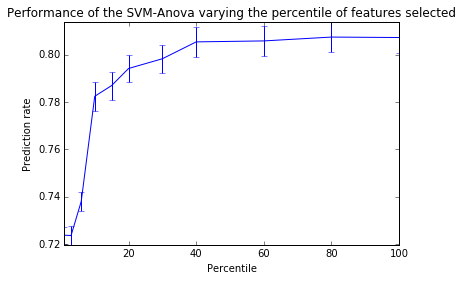

In [15]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets, feature_selection, cross_validation
from sklearn.pipeline import Pipeline

###############################################################################
X = trainX[:, ind]
y = trainY.ravel()

###############################################################################
# Create a feature-selection transform and an instance of SVM that we
# combine together to have an full-blown estimator

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', RandomForestClassifier(n_estimators=100))])

###############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using all CPUs
    this_scores = cross_validation.cross_val_score(clf, X, y, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()

In [16]:
clf.set_params(anova__percentile=40)
clf.fit(X, y)

Pipeline(steps=[('anova', SelectPercentile(percentile=40,
         score_func=<function f_classif at 0x7f5d60508f50>)), ('svc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [18]:
show_results(clf, testX[:, ind], testY)

[[79144 13324]
 [14967 32126]]
[[ 0.85590691  0.14409309]
 [ 0.31781793  0.68218207]]
accuracy 0.797285774679


In [29]:
from sklearn.feature_selection import SelectFromModel
clf = Pipeline([
  ('feature_selection', SelectFromModel(RandomForestClassifier(), threshold="0.75*mean")),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

Pipeline(steps=[('feature_selection', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_es...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [30]:
show_results(clf, testX[:, ind], testY)

[[80478 11990]
 [17860 29233]]
[[ 0.87033352  0.12966648]
 [ 0.37924957  0.62075043]]
accuracy 0.786115032136


In [35]:
clf = xgb.XGBClassifier()
clf.fit(trainX, trainY)
y

/home/iv/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBoostError: base_score must be in (0,1) for logistic loss

In [37]:
np.mean(y)
trainX.shape

(327834, 38)